In [2]:
import keras as k
import scipy

Using Theano backend.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping


from keras.models import Sequential
from keras.layers import Dense, Activation
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
home = '/home/nandhini/aozel/periodicBox'
phi=0.1
cohesion = ''

dp = 75
timestep=0.65
fsize = 9
data_signature = 'fsize' + str(fsize)+'phi'+str(phi)+'dp'+str(dp)+'timestep'+str(timestep) + cohesion
file_myData = "corrected_myDataFSUslip"+data_signature+".pickle"
file_target = "corrected_targetFSUslip"+data_signature+".pickle"

myData = pickle.load( open( file_myData, "rb" ) )
target = pickle.load( open( file_target, "rb" ) )

In [5]:
myData.shape

(1934712, 109)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(myData, target, test_size=0.5, random_state=42)

In [28]:
def get_gradients(a):
    """Average first and last element of a 1-D array"""
    x_left   = np.hstack([a[0], a[3], a[6]])
    x_middle = np.hstack([a[1], a[4], a[7]])
    x_right  = np.hstack([a[2], a[5], a[8]])
    y_0 = a[1]
    y_first  = (x_right-x_left)
    y_second = (x_right-2*x_middle + x_left)
    return np.hstack([y_0, y_first, y_second])

def get_gradients_second(a):
    """Average first and last element of a 1-D array"""
    x_left   = np.hstack([a[0], a[3], a[6]])
    x_middle = np.hstack([a[1], a[4], a[7]])
    x_right  = np.hstack([a[2], a[5], a[8]])
    y_0 = a[1]
    y_second = (x_right-2*x_middle + x_left)
    return np.hstack([y_0, y_second])

def get_gradients_first(a):
    """Average first and last element of a 1-D array"""
    x_left   = np.hstack([a[0], a[3], a[6]])
    x_middle = np.hstack([a[1], a[4], a[7]])
    x_right  = np.hstack([a[2], a[5], a[8]])
    y_0 = a[1]
    y_first  = (x_right-x_left)
    return np.hstack([y_0, y_first])

def get_gradients_none(a):
    """Average first and last element of a 1-D array"""
    x_left   = np.hstack([a[0], a[3], a[6]])
    x_middle = np.hstack([a[1], a[4], a[7]])
    x_right  = np.hstack([a[2], a[5], a[8]])
    y_0 = a[1]
    y_first  = (x_right-x_left)
    return np.hstack([y_0])

def get_gradients_first3(a):
    """Average first and last element of a 1-D array"""
    x_left   = a[0]
    x_middle = a[1]
    x_right  = a[2]
    y_0 = a[1]
    y_first  = (x_right-x_left)
    return np.hstack([y_0, y_first])

newlist1 = []
newlist2 = []
newlist3 = []

index = 0
for i in range(-1,2):
    for j in range(-1,2):
        for k in range(-1,2):
            if (i == 0 and j == 0) or (i ==0 and k == 0) or (j == 0 and k == 0): 
                if i == 0 and j == 0:
                    newlist1.append(index)
                if i == 0 and k == 0:
                    newlist2.append(index)
                if j == 0 and k == 0:
                    newlist3.append(index)
            index +=1

newlist = newlist1 + newlist2 + newlist3
phis_index =  [4*x+1 for x in newlist]
vzs_index =   [4*x+4 for x in newlist]

phis_index3 =  [4*x+1 for x in newlist1]
vzs_index3 =   [4*x+4 for x in newlist1]

def get_X_gradients(X):
    return np.hstack([X[:,:1], np.apply_along_axis(get_gradients, 1, X[:,phis_index]), 
           np.apply_along_axis(get_gradients, 1, X[:,vzs_index])])
def get_X_gradients_second(X):
    return np.hstack([X[:,:1], np.apply_along_axis(get_gradients_second, 1, X[:,phis_index]), 
           np.apply_along_axis(get_gradients_second, 1, X[:,vzs_index])])

def get_X_gradients_first(X):
    return np.hstack([X[:,:1], np.apply_along_axis(get_gradients_first, 1, X[:,phis_index]), 
           np.apply_along_axis(get_gradients_first, 1, X[:,vzs_index])])
def get_X_gradients_none(X):
    return np.hstack([X[:,:1], np.apply_along_axis(get_gradients_none, 1, X[:,phis_index]), 
           np.apply_along_axis(get_gradients_none, 1, X[:,vzs_index])])

def get_X_gradients_first3(X):
    return np.hstack([X[:,:1], np.apply_along_axis(get_gradients_first3, 1, X[:,phis_index3]), 
           np.apply_along_axis(get_gradients_first3, 1, X[:,vzs_index3])])

In [11]:
#scaler = pickle.load( open( 'FSscale_version2', "rb" ) )
#X_test_norm = scaler.transform(X_test)


(0.64797701818940501, 0.0)


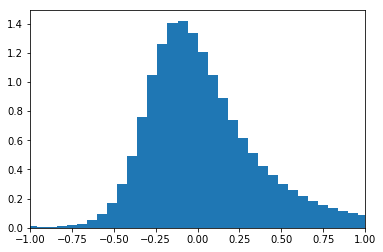

In [13]:
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=X_test_grad.shape[-1]))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'gradients_full.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_grad)
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_all= plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

(0.58653078031704919, 0.0)


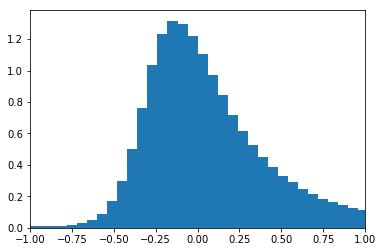

In [21]:
X_test_grad_first = get_X_gradients_first(X_test)
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=X_test_grad_first.shape[-1]))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'gradients_first.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_grad_first)
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_all= plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
b = pred.copy()
pred = pred[(b<1.5) & (b>0)]
real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

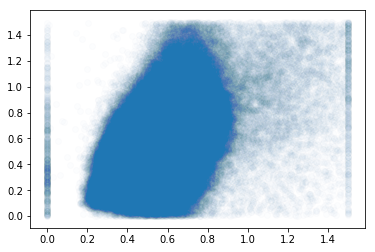

In [26]:
plt.scatter(pred,real,alpha=0.01)

(0.46902721776963791, 0.0)


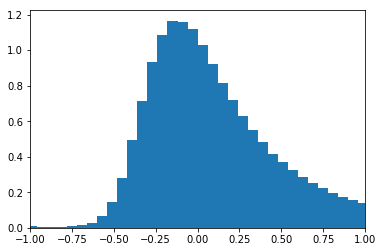

In [24]:
X_test_grad_second = get_X_gradients_second(X_test)
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=X_test_grad_second.shape[-1]))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'gradients_second.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_grad_second)
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_all= plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
b = pred.copy()
pred = pred[(b<1.5) & (b>0)]
real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

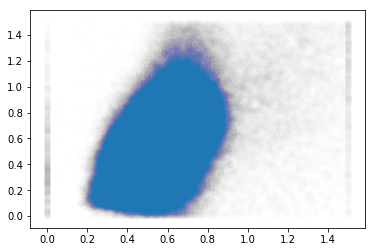

In [25]:
plt.scatter(pred,real,alpha=0.005)

(0.30975065914602573, 0.0)


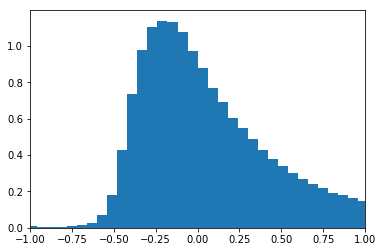

In [19]:
X_test_grad_none = get_X_gradients_none(X_test)
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=X_test_grad_none.shape[-1]))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'gradients_none.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_grad_none)
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_all= plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

(0.38521625779017005, 0.0)


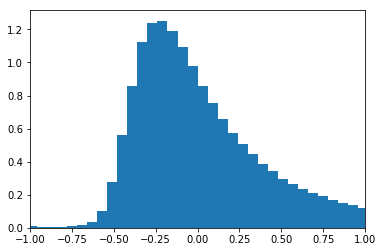

In [29]:
X_test_grad_first3 = get_X_gradients_first3(X_test)
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=X_test_grad_first3.shape[-1]))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'gradients_first3.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_grad_first3)
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_all= plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
b = pred.copy()
pred = pred[(b<1.5) & (b>0)]
real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
list_of_lists = [[4*x+1,4*x+4] for x in range(27)]
flattened = [0] + [val for sublist in list_of_lists for val in sublist] 
#flattened

In [ ]:
len(flattened)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_phi_vz.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_phi_vz = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
plt.scatter(real[:100000], pred[:100000],alpha=0.1)

In [ ]:
list_of_lists = [4*x+4 for x in range(27)]
flattened = [0] + [53] + list_of_lists
len(flattened)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_vz.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_vz = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
plt.scatter(real[:100000], pred[:100000],alpha=0.1)

In [ ]:
list_of_lists = [4*x+1 for x in range(27)]
flattened = [0] + [56] + list_of_lists
len(flattened)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_phi.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_phi = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
def get_plot_values(x):
    return (x[0], x[1][1:]+(x[1][1]-x[1][0]))

In [ ]:
alist = []
index = 0
for i in range(-1,2):
    for j in range(-1,2):
        for k in range(-1,2):
            if (i == 0 and j == 0) or (i ==0 and k == 0) or (j == 0 and k == 0): 
                alist.append(index)
            index +=1
            
            

In [ ]:
list_of_lists = [[4*x+1,4*x+4] for x in alist]
flattened = [0] + [val for sublist in list_of_lists for val in sublist] 
print('length' + str(len(flattened)))
#flattened


model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_phi_vz_seven_cells.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_phi_vz_7 = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
list_of_lists = [4*x+4 for x in alist]
flattened = [0] + [53] + list_of_lists
print('length' + str(len(flattened)))

model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_vz_seven_cells.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_vz_7 = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
list_of_lists = [4*x+1 for x in alist]
flattened = [0] + [56] + list_of_lists
print('length' + str(len(flattened)))



model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer='normal',input_dim=len(flattened)))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
save_file = 'corrected_version2_small_subset_phi_seven_cells.hdf5'
model.load_weights(save_file)

y_predict = model.predict(X_test_norm[:,np.array(flattened)])
error_percent = (y_predict.reshape(-1)- y_test.reshape(-1))/y_test.reshape(-1)
errpd_phi_7 = plt.hist(error_percent,1000,range=(-30, 30), normed=True)
plt.xlim([-1, 1])

pred = y_predict.reshape(-1)
real = y_test.reshape(-1)
pred = np.maximum(pred,0)
pred = np.minimum(pred,1.5)
a = real.copy()
pred = pred[(a<1.5) & (a>0)]
real = real[(a<1.5) & (a>0)]
#b = pred.copy()
#pred = pred[(b<1.5) & (b>0)]
#real = real[(b<1.5) & (b>0)]

print(scipy.stats.pearsonr(pred,real))

In [ ]:
fig = plt.gcf()
fig.set_size_inches(5.5, 5.5)
plt.hexbin(real[:100000], pred[:100000],gridsize=80)
plt.xlim([0,1.2])
plt.ylim([0,1.2])
plt.xlabel('Actual Values $y$',fontsize='large')
plt.ylabel('Model Predictions $\hat{y}$ ',fontsize='large')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9.9, 9.9)

plt.plot
y,x = get_plot_values(errpd_all)
plt.plot(x,y,'k-')
y,x= get_plot_values(errpd_phi_vz)
plt.plot(x,y,'k--')
y, x = get_plot_values(errpd_phi)
plt.plot(x,y,'ko-')
y, x = get_plot_values(errpd_vz)
plt.plot(x,y,'kv-')
#plt.legend(['Include both \bar{\phi}','a','d','e'])
plt.legend([r'$\bar{\phi}$ and $\mathbf{\tilde{u}}_{slip}$',
            r'$\bar{\phi}$ and $\tilde{u}_{slip,vertical}$',
            r'$\bar{\phi}$',
            r'${u}_{slip,vertical}$'],fontsize='medium')

plt.xlabel('$e_i$',fontsize='large')
plt.ylabel('Probability Density Function ',fontsize='large')
plt.xlim([-1,1])
fig.savefig('feature_importances.eps', dpi=200)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9.9, 9.9)

y, x = get_plot_values(errpd_phi)
plt.plot(x,y,'ko-')
y, x = get_plot_values(errpd_vz)
plt.plot(x,y,'kv-')
y,x= get_plot_values(errpd_phi_vz_7)
plt.plot(x,y,'k-')
y, x = get_plot_values(errpd_phi_7)
plt.plot(x,y,'k-.')
y, x = get_plot_values(errpd_vz_7)
plt.plot(x,y,'k:')
#plt.legend(['Include both \bar{\phi}','a','d','e'])
plt.legend([r'$\bar{\phi}$',
            r'${u}_{slip,vertical}$',
            r'$\bar{\phi}$ and $\tilde{u}_{slip,vertical}$, 7 cells',
            r'$\bar{\phi}$, 7 cells',
            r'${u}_{slip,vertical}$, 7 cells'],fontsize='medium')

plt.xlabel('$e_i$',fontsize='large')
plt.ylabel('Probability Density Function ',fontsize='large')
plt.xlim([-1.5,1.5])
fig.savefig('more_feature_importances.eps', dpi=200)